<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span></li><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Cleaning</a></span></li><li><span><a href="#Preprocessing-Data" data-toc-modified-id="Preprocessing-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Preprocessing Data</a></span></li><li><span><a href="#Fit-Model-to-Train-Set" data-toc-modified-id="Fit-Model-to-Train-Set-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fit Model to Train Set</a></span></li><li><span><a href="#Make-Predictions-and-Evaluate-Performance" data-toc-modified-id="Make-Predictions-and-Evaluate-Performance-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Make Predictions and Evaluate Performance</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Classification-Report" data-toc-modified-id="Classification-Report-5.0.1"><span class="toc-item-num">5.0.1&nbsp;&nbsp;</span>Classification Report</a></span></li><li><span><a href="#ROC-Curve" data-toc-modified-id="ROC-Curve-5.0.2"><span class="toc-item-num">5.0.2&nbsp;&nbsp;</span>ROC Curve</a></span></li></ul></li></ul></li><li><span><a href="#Feature-Importance" data-toc-modified-id="Feature-Importance-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Feature Importance</a></span></li><li><span><a href="#OverDispersion" data-toc-modified-id="OverDispersion-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>OverDispersion</a></span></li><li><span><a href="#Reference" data-toc-modified-id="Reference-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

# Exploratory Data Analysis

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
import numpy as np


plt.style.use('ggplot')
%matplotlib inline

In [2]:
# load data
file = 'data/cancer.data'
df = pd.read_csv(file, header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [3]:
# summary statistics
df_description = df.describe()
print(df_description)

print('\n')

# DataFrame information
df_info = df.info()
print(df_info)


                 0           1           2           3           4   \
count  6.990000e+02  699.000000  699.000000  699.000000  699.000000   
mean   1.071704e+06    4.417740    3.134478    3.207439    2.806867   
std    6.170957e+05    2.815741    3.051459    2.971913    2.855379   
min    6.163400e+04    1.000000    1.000000    1.000000    1.000000   
25%    8.706885e+05    2.000000    1.000000    1.000000    1.000000   
50%    1.171710e+06    4.000000    1.000000    1.000000    1.000000   
75%    1.238298e+06    6.000000    5.000000    5.000000    4.000000   
max    1.345435e+07   10.000000   10.000000   10.000000   10.000000   

               5           7           8           9           10  
count  699.000000  699.000000  699.000000  699.000000  699.000000  
mean     3.216023    3.437768    2.866953    1.589413    2.689557  
std      2.214300    2.438364    3.053634    1.715078    0.951273  
min      1.000000    1.000000    1.000000    1.000000    2.000000  
25%      2.000000   

# Data Cleaning

In [4]:
# Replace the '?'s with NaN
df = df.replace('?', np.nan)

In [5]:
# impute missing values with mean imputation
df.fillna(df.mean(), inplace=True)

# count the number of NANs to verify
df.isnull().sum()

0      0
1      0
2      0
3      0
4      0
5      0
6     16
7      0
8      0
9      0
10     0
dtype: int64

In [6]:
for col in df:
    if df[col].dtype == 'object':
        df = df.fillna(df[col].value_counts().index[0])
        
print(df.isnull().sum())

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
dtype: int64


> It appears there are no missing values in the data set.

> Column names need to be renamed appropriatley.


In [7]:
# rename columns
df.rename(columns = {0:'sample_code_number', 1:'clump_thickness', 2:'uniformity_cell_size', 
                    3:'uniformity_cell_shape', 4:'marginal_adhesion', 5:'single_epithelial_cell_size', 
                    6:'bare_nuclei', 7:'bland_chromatin', 8:'normal_nucleoli', 9:'mitoses', 10:'class'}, inplace = True) 

In [8]:
# replace values in class with binary values
df['class'] = df['class'].replace([2,4], [1,0])

> Sample Code Number is not a neccesssary feature in predicting breast cancer, therefore it will need to be dropped.

In [9]:
# drop sample_code_number feature and convert dataframe to numpy array
df = df.drop(['sample_code_number'], axis=1)

# segregate features and lables into separate variables
X = df[['clump_thickness', 'uniformity_cell_size', 'uniformity_cell_shape', 'marginal_adhesion',
       'single_epithelial_cell_size', 'bare_nuclei', 'bland_chromatin', 'normal_nucleoli', 'mitoses']]
y = df[['class']]

# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print(y_train.shape, X_train.shape)
print(y_test.shape, X_test.shape)

(489, 1) (489, 9)
(210, 1) (210, 9)


# Preprocessing Data

In [10]:
# instantiate MinMaxScaler and use it to rescale X_train and X_test
scaler = MinMaxScaler(feature_range=(0,1))
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.fit_transform(X_test)

# Fit Model to Train Set

In [11]:
logreg = LogisticRegression()

logreg.fit(rescaledX_train, y_train)

/home/molash/Documents/Projects/Multiple_reg/multEnv/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Make Predictions and Evaluate Performance

In [12]:
# predict instances for test and train
y_pred = logreg.predict(rescaledX_test)
y_pred_train = logreg.predict(rescaledX_train)

# confusion matrix of the model
print('Test set\n', confusion_matrix(y_test, y_pred))
print('\n')
print('Train set\n',confusion_matrix(y_train, y_pred_train))

Test set
 [[ 62   5]
 [  2 141]]


Train set
 [[164  10]
 [  8 307]]


### Classification Report


In [13]:
print('Logistic Regression classification report:')
print('Test set', classification_report(y_test, y_pred))            
print('\n')
print('Train set', classification_report(y_train, y_pred_train))

Logistic Regression classification report:
Test set               precision    recall  f1-score   support

           0       0.97      0.93      0.95        67
           1       0.97      0.99      0.98       143

    accuracy                           0.97       210
   macro avg       0.97      0.96      0.96       210
weighted avg       0.97      0.97      0.97       210



Train set               precision    recall  f1-score   support

           0       0.95      0.94      0.95       174
           1       0.97      0.97      0.97       315

    accuracy                           0.96       489
   macro avg       0.96      0.96      0.96       489
weighted avg       0.96      0.96      0.96       489



### ROC Curve 

In [14]:
logreg_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, threshold_log = roc_curve(y_test, y_pred)

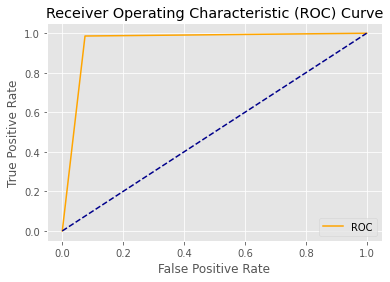

In [15]:
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Feature Importance

In [16]:
dt = DecisionTreeClassifier(random_state=7)
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=7, splitter='best')

In [17]:
dict = {'feature': X_train.columns, 'feature_importance':dt.feature_importances_}
new_df = pd.DataFrame(dict)
new_df.sort_values('feature_importance',axis=0,ascending=False,inplace=True)

In [18]:
new_df = new_df[new_df["feature_importance"] > 0.05]
new_df

,feature,feature_importance
2,uniformity_cell_shape,0.714860
5,bare_nuclei,0.133587


# OverDispersion

Overdispersion is the presence of greater variability in a data set than would be expected based on a given statistical model. In the context of logistic regression, overdispersion occurs because the mean and variance components of the model are related and depend on the same parameter that is being predicted through the independent vector.

# Reference

> https://online.stat.psu.edu/stat504/node/162/